In [ ]:
#Imports
# Enable Float64 for more stable matrix inversions.
from jax import config
import warnings
import pandas as pd
import seaborn as sns
import numpyro.distributions as npd
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(".."))
from examples.utils import (
    clean_legend,
    confidence_ellipse,
    use_mpl_style,
)

config.update("jax_enable_x64", True)


with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.key(123)

# set the default style for plotting
use_mpl_style()

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

### Definition of GPs
**Formally GPs are defined as:**\
*"... a collection of random variables, any finite number of which have a joint Gaussian distribution." (Rasmussen and Williams 2008, p. 13)*

For our purposes of regression of some true latent function $\mathit{f}\,$ we can interpret this concretely:
1. Since in regression we are unsure of the true function values at a location $\mathit{x}$, in a probabilistic modeling fashion we can think of them as **random variables** ($\mathit{X=f(x)}$), which represents our uncertainty about the function.
2. This implies that since $\mathit{f}\,$ is typically continous, and hence can be evaluated at infinitely many different $\mathit{x}\,$ we are modeling it as a collection of infinitely many random variables. In other words, we can think of our model of $\mathit{f}\,$ as a distribution over functions. This exactly corresponds to what a GP is.
3. Since for any practical use like making predictions in regression we can only ever evaluate our function at a finite number of inputs ($\mathit{X_{eval} = \mathbf{x}_{eval}^{(1)}, \dots, \mathbf{x}_{eval}^{(m)}} | m \in \{ n \in \mathbb{N} \mid n < \infty \}$),\
 we can think of this vector $\mathbf{f(x_{eval})}\,$ as the *finite number* of random variables mentioned in the above GP definition.

Text(0.5, 1.0, 'Latent Function and Evaluations')

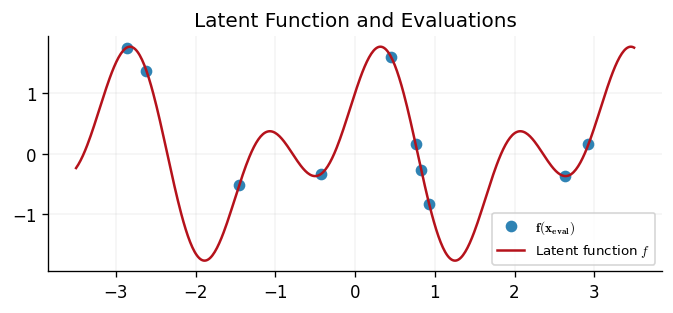

In [14]:
#Defining some example function
m = 10
noise = 0
key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(m,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

#Plot latent function and evaluations
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="$\mathbf{f(x_{eval})}$", color=cols[0])
ax.plot(xtest, ytest, label="Latent function $\mathit{f}$", color=cols[1])
ax.legend(loc="best")
ax.set_title("Latent Function and Evaluations")

4. Note, how the definition of a GP states that ***any finite number*** [of these random variables] ***have a joint Gaussian distribution***. In our interpretation this means that for any finite number of function values $\mathbf{f(x_{eval})} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$ is assumed. Actually, this means we are modeling the latent function (or all possible values of it) $\mathit{f}\,$ as an infinite-dimensional multivariate Gaussian, from which by the marginalisation property of multivariata Gaussians ($\mathbf{f(x_{eval})} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)\Rightarrow \mathit{f(x_{eval}^{(1)})} \sim \mathcal{N}(\mathit{\mu_1}, \sigma_1^2), \dots, \mathit{f(x_{eval}^{(n)})} \sim \mathcal{N}(\mathit{\mu_n}, \sigma_n^2)$) the beforementioned fact follows.

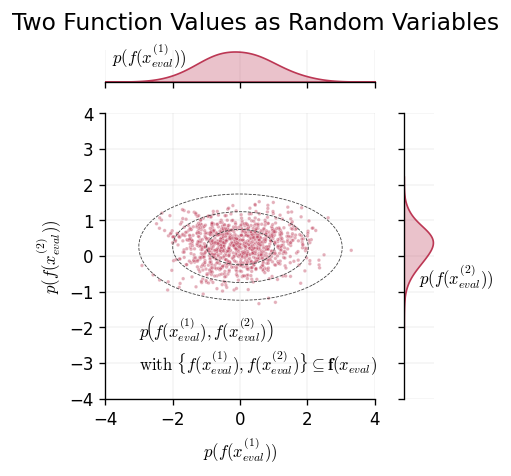

In [51]:
#Creating example data and plot for 2 fct values as random variables with joint gaussian
n = 1000
x = npd.Normal(loc=0.0, scale=1.0).sample(key, sample_shape=(n,))
key, subkey = jr.split(key)
y = npd.Normal(loc=0.25, scale=0.5).sample(subkey, sample_shape=(n,))
key, subkey = jr.split(subkey)
xfull = npd.Normal(loc=0.0, scale=1.0).sample(subkey, sample_shape=(n * 10,))
key, subkey = jr.split(subkey)
yfull = npd.Normal(loc=0.25, scale=0.5).sample(subkey, sample_shape=(n * 10,))
key, subkey = jr.split(subkey)
df = pd.DataFrame({"x": x, "y": y, "idx": jnp.ones(n)})
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", ["white", cols[1]], N=256)
# joint_text = (
#     r"$p\!\left(f(x_{eval}^{(1)}), f(x_{eval}^{(2)})\right)$" "\n"
#     r"$\mid \{f(x_{eval}^{(1)}), f(x_{eval}^{(2)})\} \subseteq \mathbf{f}(x_{eval})$"
# )
joint_text = (
    r"$p\!\left(f(x_{eval}^{(1)}), f(x_{eval}^{(2)})\right)$" "\n"
    r"$\text{with } \{f(x_{eval}^{(1)}), f(x_{eval}^{(2)})\} "
    r"\subseteq \mathbf{f}(x_{eval})$"
)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.jointplot(
        data=df,
        x="x",
        y="y",
        hue="idx",
        marker=".",
        space=0.0,
        xlim=(-4.0, 4.0),
        ylim=(-4.0, 4.0),
        height=4,
        marginal_ticks=False,
        legend=False,
        palette="inferno",
        marginal_kws={
            "fill": True,
            "linewidth": 1,
            "color": cols[1],
            "alpha": 0.3,
            "bw_adjust": 2,
            "cmap": cmap,
        },
        joint_kws={"color": cols[1], "size": 3.5, "alpha": 0.4, "cmap": cmap},
    )
    # g.ax_joint.annotate(text=r"$p(\mathit{f(x_{eval}^{(1)})}, \mathit{f(x_{eval}^{(2)})})| {\mathit{f(x_{eval}^{(1)})}, \mathit{f(x_{eval}^{(2)})}} \subseteq \mathbf{f(x_{eval})}$", xy=(-3.9, -2.0))
    g.ax_joint.annotate(text=joint_text, xy=(-3.0, -3.2))
    g.ax_marg_x.annotate(text=r"$p(\mathit{f(x_{eval}^{(1)})})$", xy=(-3.8, 0.225))
    g.ax_marg_y.annotate(text=r"$p(\mathit{f(x_{eval}^{(2)})})$", xy=(0.4, -0.78))

    g.ax_joint.set_xlabel("$p(\mathit{f(x_{eval}^{(1)})})$")
    g.ax_joint.set_ylabel("$p(\mathit{f(x_{eval}^{(2)})})$")
    confidence_ellipse(
        xfull,
        yfull,
        g.ax_joint,
        edgecolor="#3f3f3f",
        n_std=1.0,
        linestyle="--",
        linewidth=0.5,
    )
    confidence_ellipse(
        xfull,
        yfull,
        g.ax_joint,
        edgecolor="#3f3f3f",
        n_std=2.0,
        linestyle="--",
        linewidth=0.5,
    )
    confidence_ellipse(
        xfull,
        yfull,
        g.ax_joint,
        edgecolor="#3f3f3f",
        n_std=3.0,
        linestyle="--",
        linewidth=0.5,
    )
    g.figure.suptitle("Two Function Values as Random Variables", fontsize=14)
    g.figure.tight_layout()
    g.figure.subplots_adjust(top=0.9)